# Detecting payment card fraud with Temporian and TensorFlow Decision Forests

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/temporian/blob/stable/docs/src/tutorials/bank_fraud_detection_with_tfdf.ipynb)

Detection of fraud in online banking is critical for banks, businesses, and their consumers. The book "[Reproducible Machine Learning for Credit Card Fraud Detection](https://fraud-detection-handbook.github.io/fraud-detection-handbook/Foreword.html)" by Le Borgne et al. introduces the problem of payment card fraud and shows how fraud can be detected using machine learning. However, since banking transactions are sensitive and not widely available, the book uses a synthetic dataset for practical exercises.

This notebook uses the same dataset to show how to use Temporian and [TensorFlow Decision Forests](https://www.tensorflow.org/decision_forests) to detect fraud. Temporian is used for data preprocessing and augmentation, while TensorFlow Decision Forests is used for model training. Data augmentation is often critical for temporal data, and this notebook demonstrates how complex data augmentation can be performed with ease using Temporian.

The notebook is divided into three parts:

1. Download the dataset and import it to Temporian.
1. Perform various types of augmentations and visualize the correlation between the augmented features and fraud target labels.
1. Train and evaluate a machine learning model to detect fraud using the augmented features.


*Note: This notebook assumes a basic understanding of Temporian. If you are not familiar with Temporian, we recommend that you read the [3 minutes guide to Temporian](https://temporian.readthedocs.io/en/latest/3_minutes) guide first.*



## Install and import dependencies


In [27]:
# For data preprocessing and augmantation
%pip install temporian -q

# For model training
%pip install tensorflow tensorflow_decision_forests -q

# To plots and analyse the dataset
%pip install seaborn -q

# To compute the ROC curve and AUC of the model
%pip install scikit-learn -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [28]:
import datetime
import concurrent.futures
from pathlib import Path
from typing import Dict

# Temporian is used for temporal data augmentation
import temporian as tp

# Since the dataset is small, we use Pandas to load the raw data and feed augmented
# data to the model (TF-DF support Pandas DataFrame natively).
import pandas as pd

# We use Temporian to plot time sequences and other temporal data.
# We use Matplotlib and Seaborn to plot non temporal data.
import matplotlib.pyplot as plt
import seaborn as sns

# We use TensorFlow Decision Forests to train the fraud detection model using
# the features computed by Temporian.
import tensorflow_decision_forests as tfdf
import tensorflow as tf

# We use sklearn to compute the ROC curve and AUC of the TF-DF model
from sklearn import metrics as sk_metrics

The dataset consists of banking transactions sampled between April 1, 2018 and September 30, 2018. The transactions are stored in CSV files, one for each day. The transactions from April 1, 2018 to August 31, 2018 (inclusive) are used for training, while the transactions from September 1, 2018 to September 30, 2018 are used for evaluation.

In [29]:
start_date = datetime.date(2018, 4, 1)
end_date = datetime.date(2018, 9, 30)
train_test_split = datetime.datetime(2018, 9, 1)

# Note: You can reduce the end and train/test split dates to speed-up the notebook execution.

# List the input csv files
filenames = []
while start_date <= end_date:
    filenames.append(f"{start_date}.pkl")
    start_date += datetime.timedelta(days=1)
print(f"{len(filenames)} dates")

183 dates


The dataset is downloaded and converted into a Pandas dataframe.

In [30]:
path_tmp = Path("tmp") / "temporian_bank_fraud_detection"
path_downloads = path_tmp / "downloads"
path_downloads.mkdir(parents=True, exist_ok=True)

def load_date(filename):
    """ Downloads and saves pickle to cache, or loads cached. """
    cached_path = path_downloads / filename
    if cached_path.exists():
        print(">", end="", flush=True)
        df = pd.read_pickle(cached_path)
    else:
        print(".", end="", flush=True)
        df = pd.read_pickle(f"https://github.com/Fraud-Detection-Handbook/simulated-data-raw/raw/main/data/{filename}")
        df.to_pickle(cached_path)
    return df

print("Downloading dataset", end="")
# Download (or load cached) files in parallel
with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:
    frames = executor.map(load_date, filenames)
dataset_pd = pd.concat(frames)
print("done")
print(f"Found {len(dataset_pd)} transactions")

dataset_pd

Found 1754155 transactions


,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,2018-04-01 00:00:31,596,3156,57.16,31,0,0,0
1,1,2018-04-01 00:02:10,4961,3412,81.51,130,0,0,0
2,2,2018-04-01 00:07:56,2,1365,146.00,476,0,0,0
3,3,2018-04-01 00:09:29,4128,8737,64.49,569,0,0,0
4,4,2018-04-01 00:10:34,927,9906,50.99,634,0,0,0
...,...,...,...,...,...,...,...,...,...
1754150,1754150,2018-09-30 23:56:36,161,655,54.24,15810996,182,0,0
1754151,1754151,2018-09-30 23:57:38,4342,6181,1.23,15811058,182,0,0
1754152,1754152,2018-09-30 23:58:21,618,1502,6.62,15811101,182,0,0
1754153,1754153,2018-09-30 23:59:52,4056,3067,55.40,15811192,182,0,0


We only keep the following columns of interest:

- **TX_DATETIME**: The date and time of the transaction.
- **CUSTOMER_ID**: The unique identifier of the customer.
- **TERMINAL_ID**: The identifier of the terminal where the transaction was made.
- **TX_AMOUNT**: The amount of the transaction.
- **TX_FRAUD**: Whether the transaction is fraudulent (1) or not (0).

Our goal is to predict whether a transaction is fraudulent at the time of the transaction, using only the information from this transaction and previous transactions. The information about whether a transaction is fraudulent is not known at the time of the transaction. Instead, it is only known one week after the transaction. While this is too late to prevent the fraudulent transaction, it is available for future transactions.


In [31]:
dataset_pd = dataset_pd[["TX_DATETIME", "CUSTOMER_ID", "TERMINAL_ID", "TX_AMOUNT", "TX_FRAUD"]]

Convert the Pandas DataFrame into a Temporian EventSet.

In [32]:
dataset_tp = tp.from_pandas(dataset_pd, timestamps="TX_DATETIME")

dataset_tp

indexes: []
features: [('CUSTOMER_ID', str_), ('TERMINAL_ID', str_), ('TX_AMOUNT', float64), ('TX_FRAUD', int64)]
events:
     (1754155 events):
        timestamps: [1.5225e+09 1.5225e+09 1.5225e+09 ... 1.5384e+09 1.5384e+09 1.5384e+09]
        'CUSTOMER_ID': [b'596' b'4961' b'2' ... b'618' b'4056' b'3542']
        'TERMINAL_ID': [b'3156' b'3412' b'1365' ... b'1502' b'3067' b'9849']
        'TX_AMOUNT': [ 57.16  81.51 146.   ...   6.62  55.4   23.59]
        'TX_FRAUD': [0 0 0 ... 0 0 0]
memory usage: 56.1 MB

We can plot the whole dataset, but the resulting plot will be very busy because all the transactions are currently grouped together. 

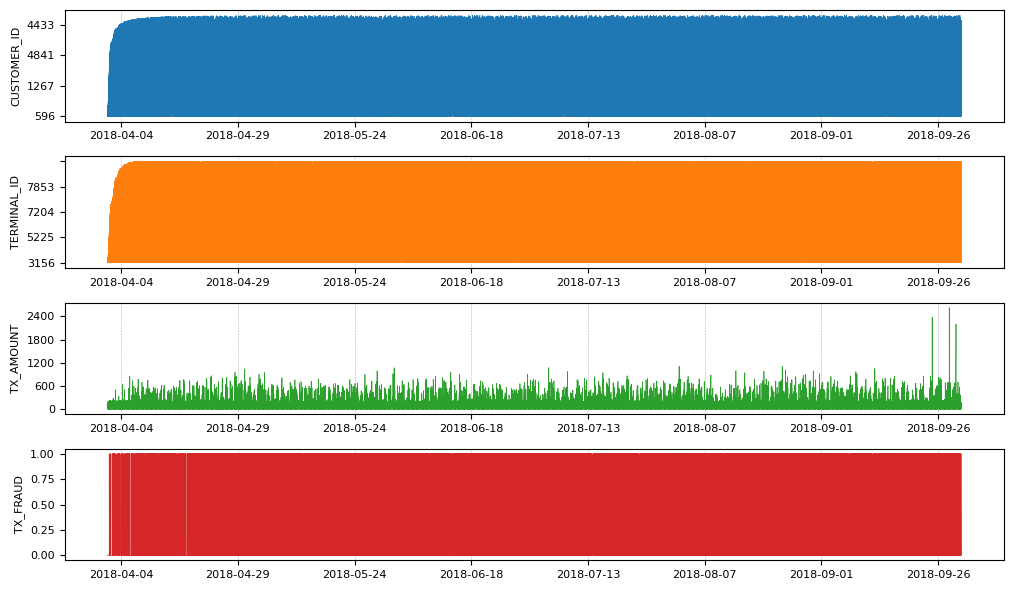

In [33]:
dataset_tp.plot()

We can also plot the transaction of a single client.

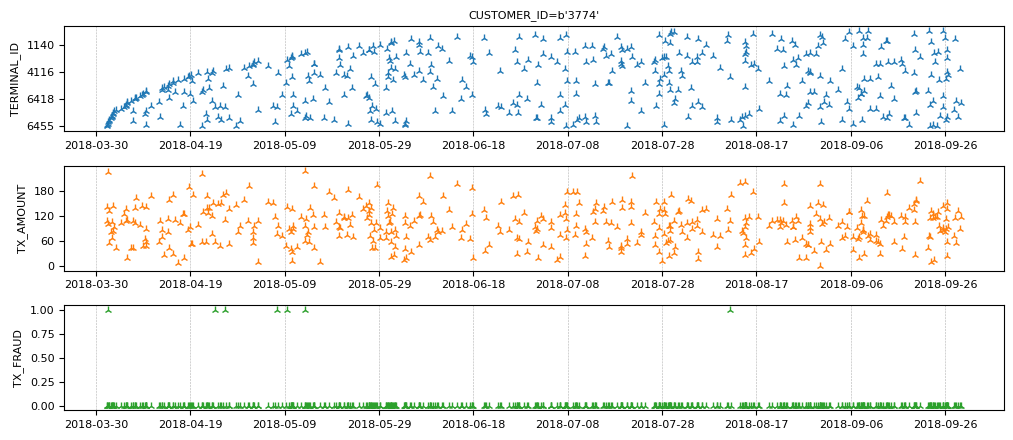

In [34]:
dataset_tp.add_index("CUSTOMER_ID").plot(indexes="3774")

# Same plot as:
# dataset_tp.filter(tp.equal_scalar(dataset_tp["CUSTOMER_ID"], "3774")).plot()

After exploring the dataset, we want to compute some augmented features that may correlate with fraudulent activities. We will compute the following three features:

**Calendar features**: Extract the hour of the day and the day of the week as individual features. This is useful because fraudulent transactions may be more likely to occur at specific times.

**Moving sum of fraud per customer**: For each client, we will extract the number of fraudulent transactions in the last 4 weeks. This is useful because clients who start to commit fraud (maybe the a card was stolen) may be more likely to commit fraud in the future. However, since we only know after a week if a transaction is fraudulent, there will be a lag in this feature.

**Moving sum of fraud per terminal**: For each terminal, we will extract the number of fraudulent transactions in the last 4 weeks. This is useful because some fraudulent transactions may be caused by ATM skimmers. In this case, many transactions from the same terminal may be fraudulent. However, since we only know after a week if a transaction is fraudulent, there will be a lag in this feature as well.

Data augmentation features often have parameters that need to be selected. For example, why look at the last 4 weeks instead of the last 8 weeks? In practice, you will want to compute the features with many different parameter values (e.g., 1 day, 2 days, 1 week, 2 weeks, 4 weeks, and 8 weeks). However, to keep this example simple, we will only use 4 weeks here.


In [35]:
@tp.compile
def augment_transactions(transactions: tp.EventSetOrNode) -> Dict[str, tp.EventSetOrNode]:
    """Temporian function to augment the transactions with temporal features."""
    print("TRANSACTIONS:\n", transactions.schema, sep = '')

    # Create a unique ID for each transaction.
    transaction_id = transactions.enumerate().rename("transaction_id")
    transactions = tp.glue(transactions, transaction_id)

    # 1.
    # Hour of day and day of week of each transaction.
    calendar = tp.glue(
        transactions.calendar_hour(),
        transactions.calendar_day_of_week(),
        transactions["transaction_id"],
    )
    print("CALENDAR:\n", calendar.schema, sep = '')

    # 2.
    # Index the transactions per customer
    per_customer = transactions.add_index("CUSTOMER_ID")
    # Lag the fraud by 1 week
    lagged_fraud_per_customer = per_customer["TX_FRAUD"].lag(tp.duration.weeks(1))
    # Moving sum of transactions over the last 4 weeks
    feature_per_customer = lagged_fraud_per_customer.moving_sum(tp.duration.weeks(4), sampling=per_customer)
    # Rename the feature for book-keeping
    feature_per_customer = feature_per_customer.rename("per_customer.moving_sum_frauds")
    # Aggregate the newly computed feature with the ther customer features.
    feature_per_customer = tp.glue(feature_per_customer, per_customer)
    # Print the schema
    print("PER CUSTOMER:\n", per_customer.schema, sep = '')

    # 3.
    # The moving sum of fraud per terminal is similar to the moving sum per customer.
    # Instead of indexing by customer, the dataset is indexed by terminal.
    per_terminal = transactions.add_index("TERMINAL_ID")
    lagged_fraud_per_terminal = per_terminal["TX_FRAUD"].lag(tp.duration.weeks(1))
    feature_per_terminal = lagged_fraud_per_terminal.moving_sum(tp.duration.weeks(4), sampling=per_terminal)
    feature_per_terminal = feature_per_terminal.rename("per_terminal.moving_sum_frauds")
    feature_per_terminal = tp.glue(feature_per_terminal, per_terminal)
    print("PER TERMINAL:\n", per_terminal.schema, sep = '')

    # Join the per customer and per terminal features
    augmented_transactions = feature_per_terminal.drop_index().join(
        feature_per_customer.drop_index()[["per_customer.moving_sum_frauds","transaction_id"]],
        on="transaction_id")
    
    # Join the calendar features
    augmented_transactions = augmented_transactions.join(
        calendar[["calendar_hour", "calendar_day_of_week", "transaction_id"]],
        on="transaction_id")
    
    print("AUGMENTED TRANSACTIONS:\n", augmented_transactions.schema)

    return {"output": augmented_transactions}

# Compute the augmanted features
augmented_dataset_tp = augment_transactions(dataset_tp)["output"]

TRANSACTIONS:
features: [('CUSTOMER_ID', str_), ('TERMINAL_ID', str_), ('TX_AMOUNT', float64), ('TX_FRAUD', int64)]
indexes: []
is_unix_timestamp: True

CALENDAR:
features: [('calendar_hour', int32), ('calendar_day_of_week', int32), ('transaction_id', int64)]
indexes: []
is_unix_timestamp: True

PER CUSTOMER:
features: [('TERMINAL_ID', str_), ('TX_AMOUNT', float64), ('TX_FRAUD', int64), ('transaction_id', int64)]
indexes: [('CUSTOMER_ID', str_)]
is_unix_timestamp: True

PER TERMINAL:
features: [('CUSTOMER_ID', str_), ('TX_AMOUNT', float64), ('TX_FRAUD', int64), ('transaction_id', int64)]
indexes: [('TERMINAL_ID', str_)]
is_unix_timestamp: True

AUGMENTED TRANSACTIONS:
 features: [('per_terminal.moving_sum_frauds', int64), ('CUSTOMER_ID', str_), ('TX_AMOUNT', float64), ('TX_FRAUD', int64), ('transaction_id', int64), ('TERMINAL_ID', str_), ('per_customer.moving_sum_frauds', int64), ('calendar_hour', int32), ('calendar_day_of_week', int32)]
indexes: []
is_unix_timestamp: True



Plot the augmented features on the selected customer.

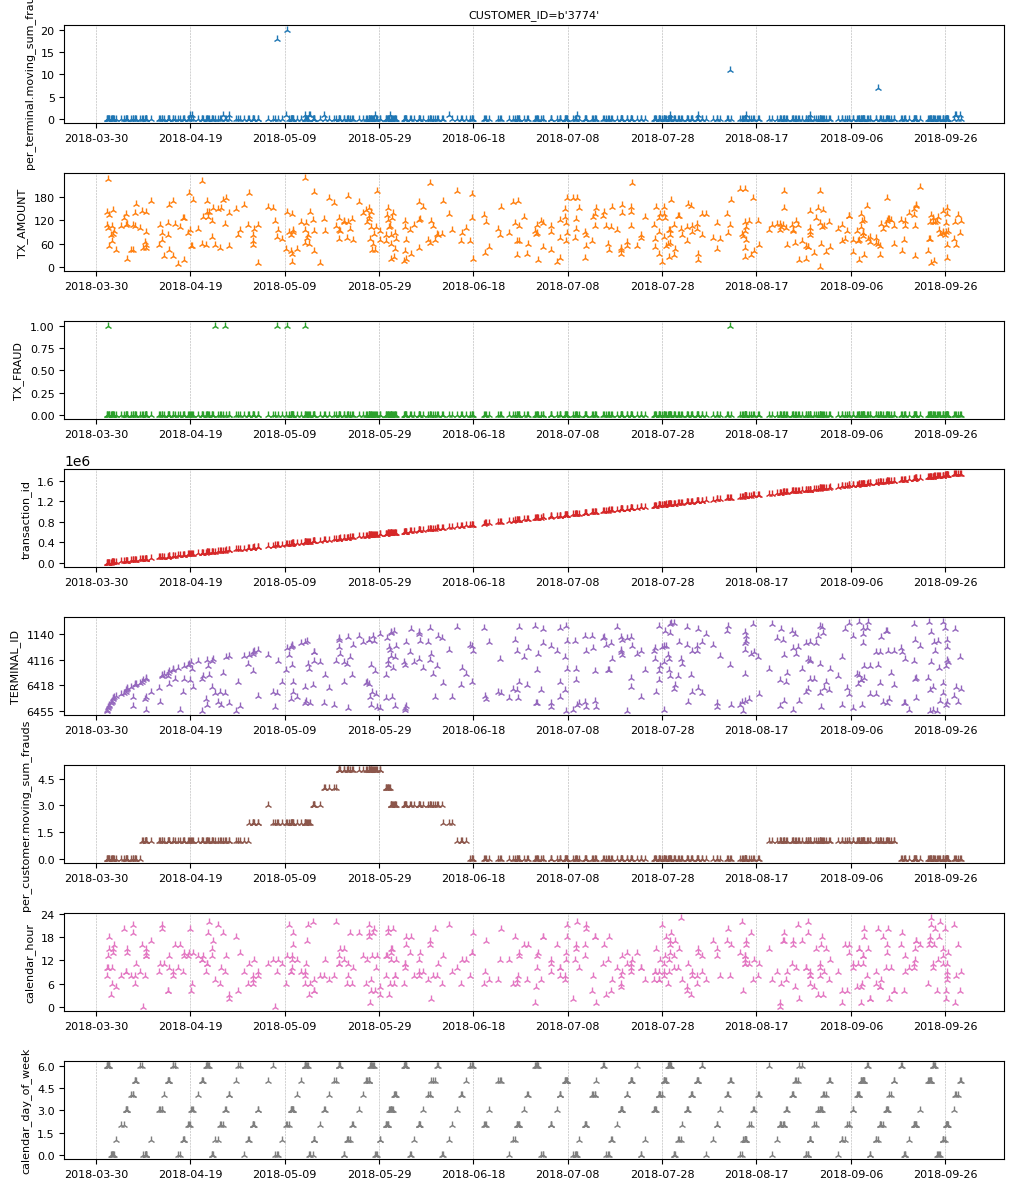

In [36]:
augmented_dataset_tp.add_index("CUSTOMER_ID").plot(indexes="3774")

Save the Temporian program that computes the augmented transactions to disk.
We will not use this program again in this notebook, but in practice, this data augmentation stage should be included with the model.

A saved Temporian program can be reloaded later or applied on a large dataset using the [Apache Beam](https://beam.apache.org/) backend.

In [37]:
tp.save(augment_transactions, transactions=dataset_tp, path="/tmp/augment_transactions.tempo")

TRANSACTIONS:
features: [('CUSTOMER_ID', str_), ('TERMINAL_ID', str_), ('TX_AMOUNT', float64), ('TX_FRAUD', int64)]
indexes: []
is_unix_timestamp: True

CALENDAR:
features: [('calendar_hour', int32), ('calendar_day_of_week', int32), ('transaction_id', int64)]
indexes: []
is_unix_timestamp: True

PER CUSTOMER:
features: [('TERMINAL_ID', str_), ('TX_AMOUNT', float64), ('TX_FRAUD', int64), ('transaction_id', int64)]
indexes: [('CUSTOMER_ID', str_)]
is_unix_timestamp: True

PER TERMINAL:
features: [('CUSTOMER_ID', str_), ('TX_AMOUNT', float64), ('TX_FRAUD', int64), ('transaction_id', int64)]
indexes: [('TERMINAL_ID', str_)]
is_unix_timestamp: True

AUGMENTED TRANSACTIONS:
 features: [('per_terminal.moving_sum_frauds', int64), ('CUSTOMER_ID', str_), ('TX_AMOUNT', float64), ('TX_FRAUD', int64), ('transaction_id', int64), ('TERMINAL_ID', str_), ('per_customer.moving_sum_frauds', int64), ('calendar_hour', int32), ('calendar_day_of_week', int32)]
indexes: []
is_unix_timestamp: True



Plot the relation between the augmented features and the label.

**Observations:** The feature `per_terminal.moving_sum_frauds` and `per_customer.moving_sum_frauds` seems to discriminate between fraudulent and non-fraudulent transactions, while the calendar features are not discriminative.

<Axes: xlabel='calendar_day_of_week', ylabel='Proportion'>

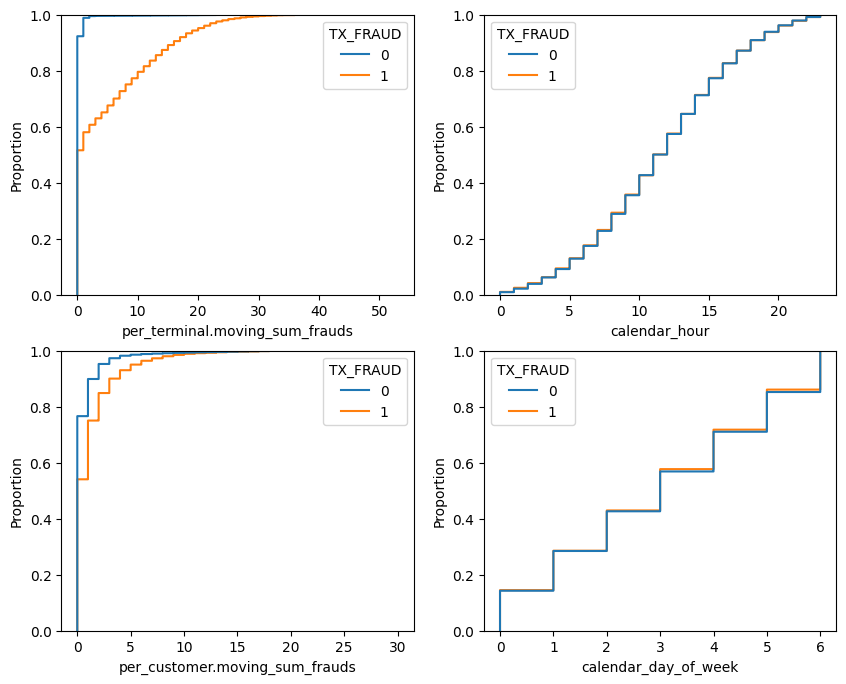

In [38]:
augmented_dataset_pd = tp.to_pandas(augmented_dataset_tp)

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10, 8))

sns.ecdfplot(data=augmented_dataset_pd, x="per_terminal.moving_sum_frauds", hue="TX_FRAUD", ax=axs[0,0])
sns.ecdfplot(data=augmented_dataset_pd, x="per_customer.moving_sum_frauds", hue="TX_FRAUD", ax=axs[1,0])
sns.ecdfplot(data=augmented_dataset_pd, x="calendar_hour", hue="TX_FRAUD", ax=axs[0,1])
sns.ecdfplot(data=augmented_dataset_pd, x="calendar_day_of_week", hue="TX_FRAUD", ax=axs[1,1])

The next step is to split the dataset into a training and testing dataset.

One common approach is to use the `EventSet.timestamps()` operator. This operator converts the timestamp of a transaction into a feature that can be compared to `train_test_split`.

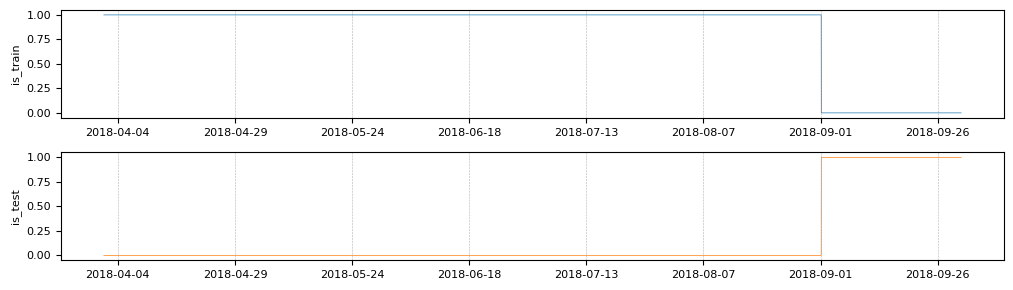

In [39]:
is_train = augmented_dataset_tp.timestamps() < train_test_split.timestamp()
is_test = ~is_train

# Plot
is_train = is_train.rename("is_train")
is_test = is_test.rename("is_test")
tp.plot([is_train, is_test])

An alternative and equivalent solution is to create a demarcating event that separates the training and testing examples. We can then use the `EventSet.since_last()` and `EventSet.isnan()` operators to compute for each transaction whether the demarcating event has already been seen.

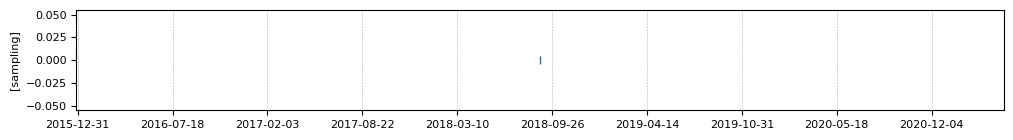

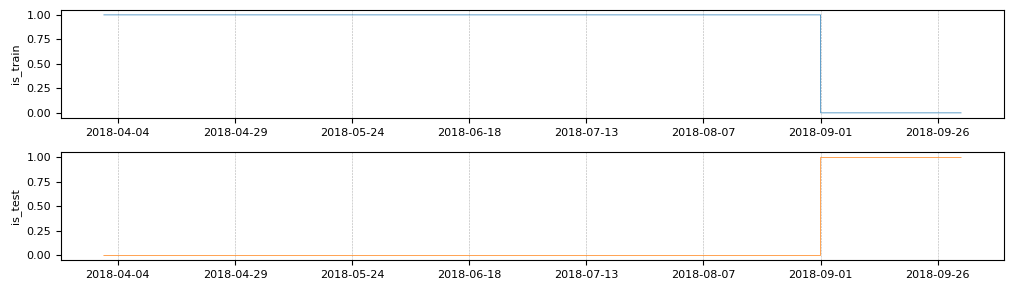

In [40]:
# Create a demarcating event.
train_test_switch_tp = tp.event_set(timestamps=[train_test_split])

# Plot
train_test_switch_tp.plot()

# All the transactions before the demarcating event are part of the training dataset (i.e. `is_train=True`) 
is_train = tp.isnan(train_test_switch_tp.since_last(augmented_dataset_tp))
is_test = ~is_train

# Plot
is_train = is_train.rename("is_train")
is_test = is_test.rename("is_test")
tp.plot([is_train, is_test])

We can now split the dataset into training and testing.

In [41]:
augmented_dataset_train_tp = augmented_dataset_tp.filter(is_train)
augmented_dataset_test_tp = augmented_dataset_tp.filter(is_test)

# Print the schema of the training dataset
augmented_dataset_train_tp.schema.features

[('per_terminal.moving_sum_frauds', int64),
 ('CUSTOMER_ID', str_),
 ('TX_AMOUNT', float64),
 ('TX_FRAUD', int64),
 ('transaction_id', int64),
 ('TERMINAL_ID', str_),
 ('per_customer.moving_sum_frauds', int64),
 ('calendar_hour', int32),
 ('calendar_day_of_week', int32)]

We first convert the Temporal EventSets into Pandas DataFrames. Then, we use the `tfdf.keras.pd_dataframe_to_tf_dataset` function to convert these DataFrames into TensorFlow datasets that can be used by TensorFlow Decision Forests.

In [42]:
# Temporian EventSet to Pandas DataFrame
dataset_train_pd = tp.to_pandas(augmented_dataset_train_tp)
dataset_test_pd = tp.to_pandas(augmented_dataset_test_tp)

print(f"Train example: {len(dataset_train_pd)}")
print(f"Test example: {len(dataset_test_pd)}")

# Pandas DataFrame to TensorFlow Dataset
dataset_train_tf = tfdf.keras.pd_dataframe_to_tf_dataset(dataset_train_pd, label="TX_FRAUD")
dataset_test_tf = tfdf.keras.pd_dataframe_to_tf_dataset(dataset_test_pd, label="TX_FRAUD")

Train example: 1466282
Test example: 287873


We can then train a TF-DF model.

In [43]:
model_path = path_tmp / "gbm.model"
if model_path.exists():
    model = tf.keras.models.load_model(model_path)
else:
    model = tfdf.keras.GradientBoostedTreesModel(features=[tfdf.keras.FeatureUsage("per_customer.moving_sum_frauds"),
                                                           tfdf.keras.FeatureUsage("per_terminal.moving_sum_frauds"),
                                                           tfdf.keras.FeatureUsage("calendar_hour"),
                                                           tfdf.keras.FeatureUsage("calendar_day_of_week"),
                                                          ],
                                                 exclude_non_specified_features=True)
    model.fit(dataset_train_tf, verbose=2)
    model.save(model_path)

[INFO 23-07-24 14:53:17.6808 -03 kernel.cc:1243] Loading model from path tmp/temporian_bank_fraud_detection/gbm.model/assets/ with prefix 1c67ef1ccf4444f1
[INFO 23-07-24 14:53:17.6898 -03 abstract_model.cc:1312] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-24 14:53:17.6898 -03 kernel.cc:1075] Use fast generic engine


Finally, we plot the ROC (Receiver operating characteristic) curve and compute the AUC (Area Under the Curve).

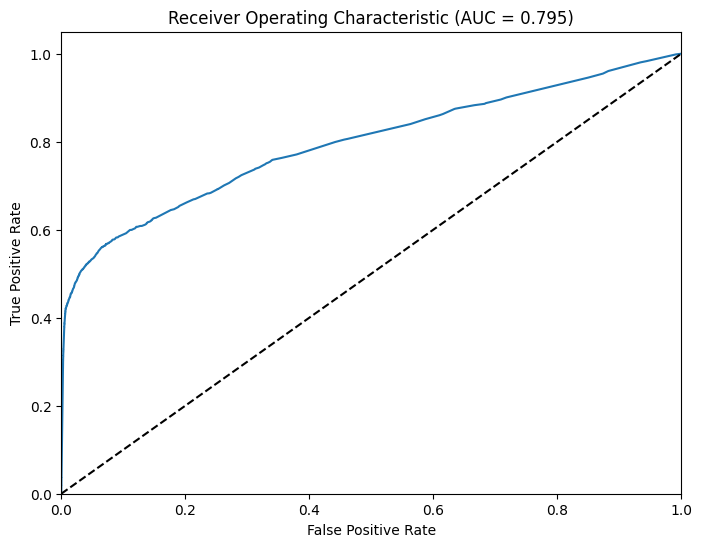

In [44]:
# Predictions of the model
test_predictions = model.predict(dataset_test_tf, verbose=0)[:,0]

# The real fraud information
test_labels = dataset_test_pd["TX_FRAUD"].values

# Compute the ROC and AUC.
fpr, tpr, thresholds = sk_metrics.roc_curve(test_labels, test_predictions)
auc = sk_metrics.roc_auc_score(test_labels, test_predictions)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (AUC = %0.3f)'  % auc )
plt.show()

**Observations:**

- The AUC of 0.79 shows the capability of the model to detect frauds.
- The augmented features we created are efficient at identifying some types of fraud, as evidenced by the recall at low FPR (see FPR=0.02, TPR=0.5).
- However, for FPRs greater than 0.02, the TPR increases slowly, indicating that the remaining types of fraud are more difficult to detect. We need to conduct further analysis and create new features to improve our ability to detect these remaining frauds.

**Homeworks**

Do you have any ideas for other features or feature augmentations that could improve the model's performance? For example, we could compute features per customer and per terminal, or we could create features related to transaction amount. These changes could help us reach an AUC of >0.88.
